## 標準バーの作成

規則的なサンプリングに同期させて均一な系列に変換したデータ

種類：タイムバー、ティックバー、ボリュームバー、ドルバー

参考：
https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Tick%2C%20Volume%2C%20Dollar%20Volume%20Bars.ipynb



###前処理１　Googleドライブマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###前処理２　データの取得

今回扱うデータとして、ビットコインの情報を使って各バーの実装を確認したいと思います。

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from tqdm import tqdm, tqdm_notebook
from datetime import datetime

# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 

data = pd.read_csv('drive/My Drive/20210622.csv')
data = data.append(pd.read_csv('drive/My Drive/20210623.csv')) # add a few more days
data = data.append(pd.read_csv('drive/My Drive/20210624.csv'))
data = data.append(pd.read_csv('drive/My Drive/20210625.csv'))
data = data[data.symbol == 'XBTUSD']


# timestamp parsing
data['timestamp'] = data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

取引金額を求めてデータフレームに追加する

In [4]:
data['total'] = data['price'] * data['size']
data.tail()

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,total
356991,2021-06-25 23:59:55.554345,XBTUSD,Sell,100,31568.0,ZeroPlusTick,793a27bf-d078-107f-0fb1-6489de8fb1e1,316776,0.003168,100.0,3156800.0
356992,2021-06-25 23:59:55.966135,XBTUSD,Buy,100,31562.5,MinusTick,35d3c0d2-bdb0-b6a5-1223-88ce2b124293,316832,0.003168,100.0,3156250.0
356993,2021-06-25 23:59:59.894261,XBTUSD,Buy,29600,31562.5,ZeroMinusTick,8e56a4ad-26e4-c6c0-a5c7-29d339c08f18,93782272,0.937823,29600.0,934250000.0
356994,2021-06-25 23:59:59.894261,XBTUSD,Buy,20400,31562.5,ZeroMinusTick,a5dec5f9-5be6-a74f-961b-642825e2f3fd,64633728,0.646337,20400.0,643875000.0
356995,2021-06-25 23:59:59.995359,XBTUSD,Buy,200,31562.5,ZeroMinusTick,c88ce0ae-55e5-f232-3a0f-e8671ddde53a,633664,0.006337,200.0,6312500.0


### ティックバー

指定件数ごとにバーを取得する指定した取引数に達する毎に、カウントした取引の加重平均レート、タイムスタンプ、バー取得時の中値、BID、ASKなどを抽出する

今回は指定件数となった対象の注文情報を保持し、その注文の約定価格を利用して
グラフにバーを表示する。

例：１００件取引したらバーを取得する

In [5]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars

    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column] # price data
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)): # iにはインデックスが入っている xには約定価格が入っている
        ts += 1
        if ts >= m:        # 指定した取引数に達した場合
            idx.append(i)  # 行番号を取得する
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

In [7]:
tick_M = 100 # arbitrary
print(f'tick threshold: {tick_M:,}')
tick_df = tick_bar_df(data, 'price', tick_M)
print(tick_df.shape)
tick_df.tail()

 24%|██▍       | 184678/759266 [00:00<00:00, 1846772.96it/s]

tick threshold: 100


100%|██████████| 759266/759266 [00:00<00:00, 1998442.72it/s]


(7592, 11)


,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,total
356529,2021-06-25 23:53:28.680599,XBTUSD,Sell,100,31681.0,MinusTick,422dfb17-f83b-8d67-ee99-5cd6d83e25e6,315647,0.003156,100.0,3.168100e+06
356629,2021-06-25 23:55:42.061883,XBTUSD,Sell,30200,31703.0,ZeroMinusTick,c51a46eb-fe77-ecf4-bafa-83b91457e450,95259256,0.952593,30200.0,9.574306e+08
356729,2021-06-25 23:57:24.633000,XBTUSD,Buy,40000,31622.0,ZeroPlusTick,61220c51-8f6d-4420-2160-9ca9672e2f63,126494400,1.264944,40000.0,1.264880e+09
356829,2021-06-25 23:59:08.011565,XBTUSD,Sell,800,31594.5,ZeroMinusTick,ec81d183-c752-b9eb-df6b-3c096cc6950e,2532088,0.025321,800.0,2.527560e+07
356929,2021-06-25 23:59:26.393195,XBTUSD,Sell,300,31576.0,MinusTick,9f2b1ada-824a-bb7e-9be0-bba5e6a63071,950088,0.009501,300.0,9.472800e+06


### 取引の約定価格のグラフにティックバー表示

(6403, 11)
(64, 11)


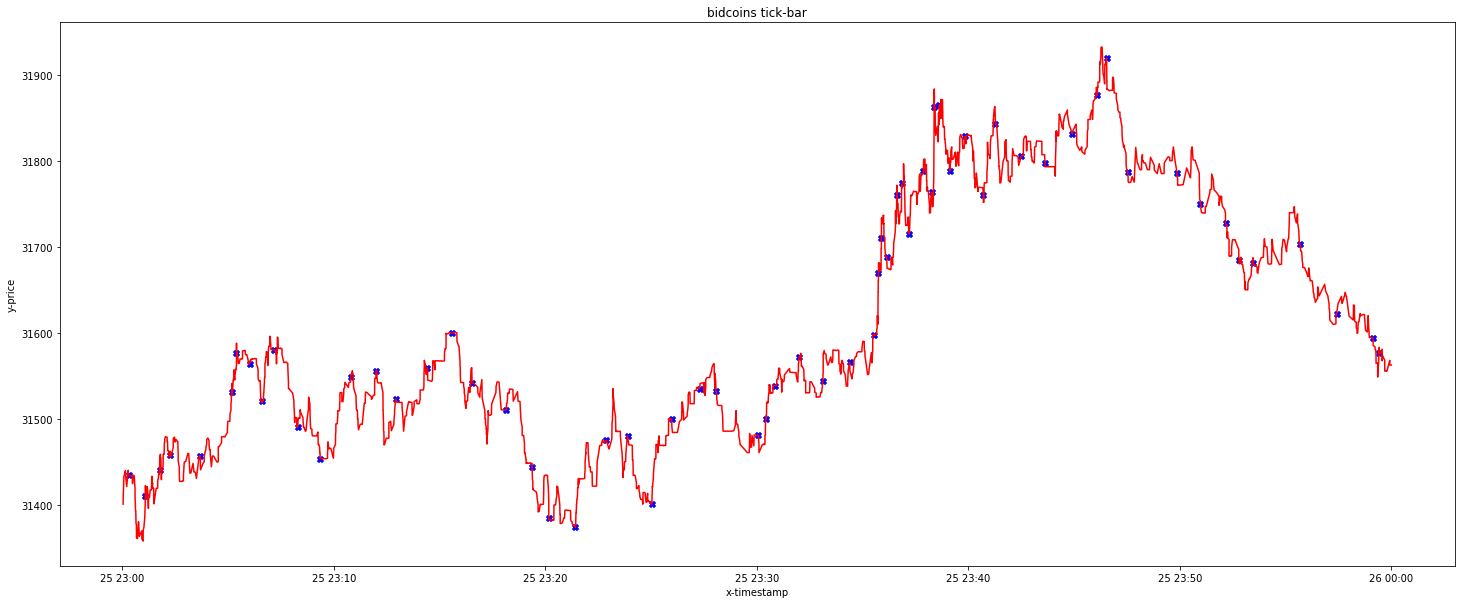

In [8]:
#ティックデータのグラフデータの取得　数が多いので時間で絞る
xdata1 = data[data['timestamp'] > dt.datetime(2021,6,25,23)]
x1=xdata1['timestamp']
y1=xdata1['price']
print(xdata1.shape)

#ティックバーデータのグラフデータの取得　数が多いので時間で絞る
xdata2 = tick_df[tick_df['timestamp'] > dt.datetime(2021,6,25,23)]
x2=xdata2['timestamp']
y2=xdata2['price']
print(xdata2.shape)

# グラフの描画
plt.rcParams["figure.figsize"] = (25, 13)

plt.plot(x1, y1, color = "red")
plt.scatter(x2, y2, marker='X', color = "blue")

plt.title("bidcoins tick-bar")
plt.xlabel('x-timestamp')
plt.ylabel('y-price')

plt.show()


### ボリュームバー

指定数量ごとにバーを取得する指定した取引数量に達する毎に、カウントした取引の加重平均レート、タイムスタンプ、バー取得時の中値、BID、ASKなどを抽出する

今回は指定取引数量となった対象の注文情報を保持し、その注文の約定価格を利用してグラフにバーを表示する。

例：100000取引数量になったらバーを取得する

In [9]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    amtsum = []
    for i, x in enumerate(tqdm(t)): # iにはインデックスが入っている xには数量が入っている
        ts += x
        if ts >= m:        # 指定した取引数量に達した場合
            idx.append(i)  # 行番号を追加する
            amtsum.append(ts) # 指定した数量に達した時の取引数量の値を保存
            ts = 0
            continue
    return idx, amtsum

def volume_bar_df(df, volume_column, m):
    idx,amtsum = volume_bars(df, volume_column, m)
    bar_df = df.iloc[idx].drop_duplicates()
    bar_df['amtsum'] = amtsum
    return bar_df

In [10]:
volume_M = 100000 # arbitrary 
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(data, 'size', volume_M)
print(v_bar_df.shape)
v_bar_df.tail()

 22%|██▏       | 166327/759266 [00:00<00:00, 1663263.66it/s]

volume threshold: 100,000


100%|██████████| 759266/759266 [00:00<00:00, 1771008.70it/s]


(52236, 12)


,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,total,amtsum
356946,2021-06-25 23:59:34.246055,XBTUSD,Buy,14700,31568.0,ZeroPlusTick,a85eb0c9-8e9b-84cd-5f8a-e9fc69627f3f,46566072,0.465661,14700.0,4.640496e+08,106700
356958,2021-06-25 23:59:41.445516,XBTUSD,Sell,8900,31558.5,MinusTick,3f31f7d8-0bd3-fc1b-f602-c0b4d76a8932,28201608,0.282016,8900.0,2.808706e+08,100100
356965,2021-06-25 23:59:45.546682,XBTUSD,Buy,40900,31556.0,PlusTick,64c7a12a-96d1-004c-a3b9-0c4480cecbd3,129610873,1.296109,40900.0,1.290640e+09,118600
356976,2021-06-25 23:59:48.200514,XBTUSD,Buy,25000,31556.0,ZeroPlusTick,40a33075-c188-7b17-26af-8e136f457df2,79224250,0.792243,25000.0,7.889000e+08,106600
356993,2021-06-25 23:59:59.894261,XBTUSD,Buy,29600,31562.5,ZeroMinusTick,8e56a4ad-26e4-c6c0-a5c7-29d339c08f18,93782272,0.937823,29600.0,9.342500e+08,121600


### 取引の約定価格のグラフにボリュームバー表示

(6403, 11)
354
354
(354, 12)


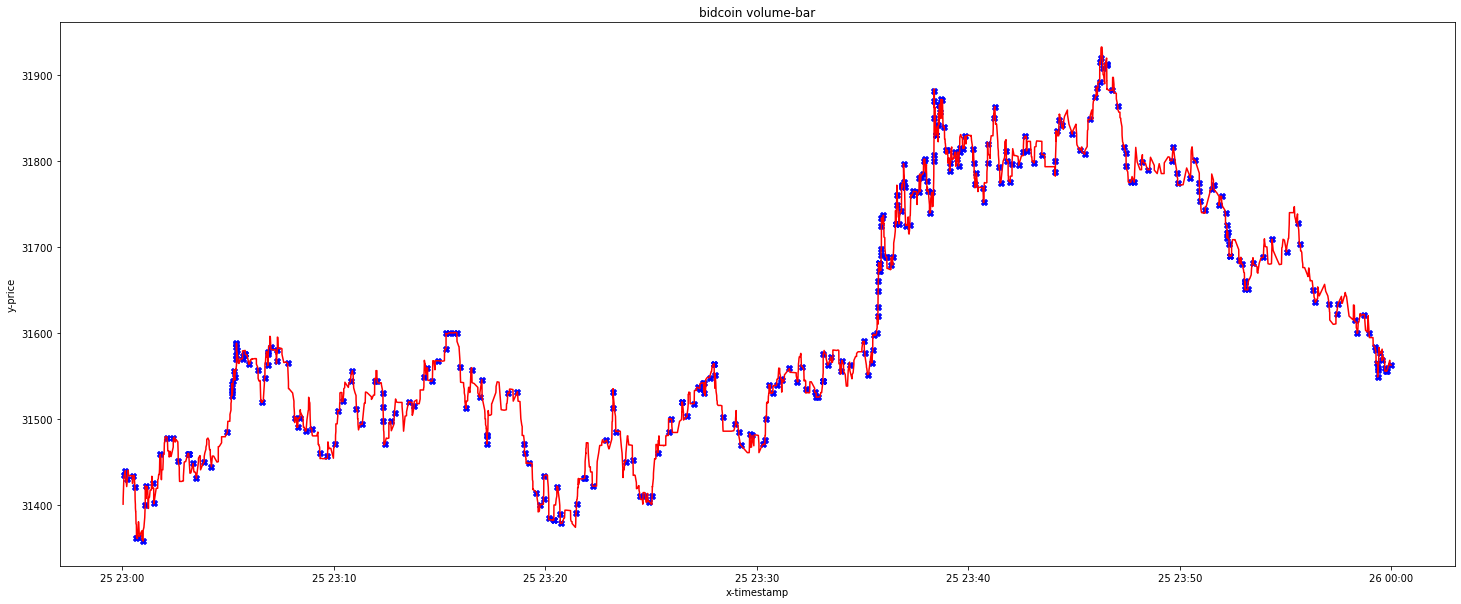

In [11]:
#ティックデータのグラフデータの取得　数が多いので時間で絞る
xdata1 = data[data['timestamp'] > dt.datetime(2021,6,25,23)]
x1=xdata1['timestamp']
y1=xdata1['price']
print(xdata1.shape)

#ティックバーデータのグラフデータの取得　数が多いので時間で絞る
xdata2 = v_bar_df[v_bar_df['timestamp'] > dt.datetime(2021,6,25,23)]
x2=xdata2['timestamp']
y2=xdata2['price']
print(len(y2))

y3=xdata2['amtsum']
print(len(y3))
print(xdata2.shape)


# グラフの描画
plt.rcParams["figure.figsize"] = (25, 13)

plt.plot(x1, y1, color = "red")
plt.scatter(x2, y2, marker='X', color = "blue")

plt.title("bidcoin volume-bar")
plt.xlabel('x-timestamp')
plt.ylabel('y-price')

plt.show()


### ドルバー

指定取引金額ごとにバーを取得する指定した取引金額に達する毎に、カウントした取引の加重平均レート、タイムスタンプ、バー取得時の中値、BID、ASKなどを抽出する

今回は指定取引金額となった対象の注文情報を保持し、その注文の約定価格を利用してグラフにバーを表示する。

例：100000000取引金額になったらバーを取得する

In [63]:
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars

    # args
        df: pd.DataFrame()
        dv_column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    totalsum = []    
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            totalsum.append(ts)
            ts = 0
            continue
    return idx,totalsum

def dollar_bar_df(df, dv_column, m):
    idx,totalsum = dollar_bars(df, dv_column, m)
    bar_df = df.iloc[idx].drop_duplicates()
    print(type(totalsum))
    bar_df['totalsum'] = totalsum
    return bar_df


In [64]:
dollar_M =100000000 # arbitrary 
print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(data, 'total', dollar_M)
print(v_bar_df.shape)
v_bar_df.tail()

 18%|█▊        | 134958/759266 [00:00<00:00, 1349574.85it/s]

dollar threshold: 100,000,000


100%|██████████| 759266/759266 [00:00<00:00, 1519584.84it/s]


<class 'list'>
(52236, 12)


,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,total,amtsum
356946,2021-06-25 23:59:34.246055,XBTUSD,Buy,14700,31568.0,ZeroPlusTick,a85eb0c9-8e9b-84cd-5f8a-e9fc69627f3f,46566072,0.465661,14700.0,4.640496e+08,106700
356958,2021-06-25 23:59:41.445516,XBTUSD,Sell,8900,31558.5,MinusTick,3f31f7d8-0bd3-fc1b-f602-c0b4d76a8932,28201608,0.282016,8900.0,2.808706e+08,100100
356965,2021-06-25 23:59:45.546682,XBTUSD,Buy,40900,31556.0,PlusTick,64c7a12a-96d1-004c-a3b9-0c4480cecbd3,129610873,1.296109,40900.0,1.290640e+09,118600
356976,2021-06-25 23:59:48.200514,XBTUSD,Buy,25000,31556.0,ZeroPlusTick,40a33075-c188-7b17-26af-8e136f457df2,79224250,0.792243,25000.0,7.889000e+08,106600
356993,2021-06-25 23:59:59.894261,XBTUSD,Buy,29600,31562.5,ZeroMinusTick,8e56a4ad-26e4-c6c0-a5c7-29d339c08f18,93782272,0.937823,29600.0,9.342500e+08,121600


取引の約定価格のグラフにドルバー表示

(6403, 11)
(2961, 12)


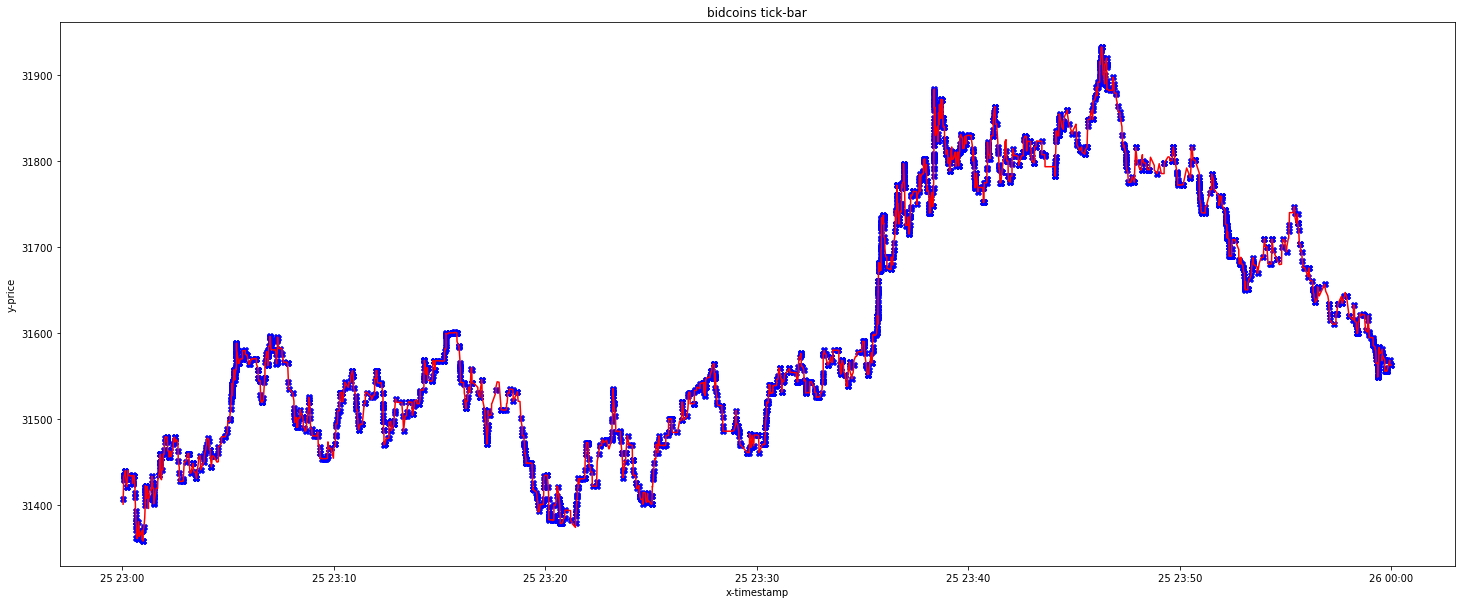

In [14]:
xdata1 = data[data['timestamp'] > dt.datetime(2021,6,25,23)]
x1=xdata1['timestamp']
y1=xdata1['price']
print(xdata1.shape)

xdata2 = dv_bar_df[dv_bar_df['timestamp'] > dt.datetime(2021,6,25,23)]
x2=xdata2['timestamp']
y2=xdata2['price']
print(xdata2.shape)

# グラフの描画
plt.rcParams["figure.figsize"] = (25, 13)

plt.plot(x1, y1, color = "red")
plt.scatter(x2, y2, marker='X', color = "blue")

plt.title("bidcoins tick-bar")
plt.xlabel('x-timestamp')
plt.ylabel('y-price')

plt.show()

### ドルインバランスバー

指定数量の一定区間における売買の期待値を実際の取引が超えた毎に、カウントした取引の加重平均レート、タイムスタンプ、バー取得時の中値、BID、ASKなどを抽出する

今回は期待値と区間の情報を適当に割り当て、区間の開始と終了時間を抽出し、
区間終了時の約定価格を利用してグラフにバーを表示する。

  https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba

In [15]:
#Δpを求める　一つ前の取引お価格と現対象取引の価格の差をとる
def numba_isclose(a,b,rel_tol=1e-09,abs_tol=0.0):
    return np.fabs(a-b) <= np.fmax(rel_tol*np.fmax(np.fabs(a), np.fabs(b)), abs_tol)

#Δpの情報が０かどうかを調べて現対象取引の不均衡符号を立てる
def bt(p0, p1, bs):
    #if math.isclose((p1 - p0), 0.0, abs_tol=0.001):
    if numba_isclose((p1-p0),0.0,abs_tol=0.001):
        b = bs[-1]
        return b
    else:
        b = np.abs(p1-p0)/(p1-p0)
        return b

#ティックの不均衡を求める関数
def get_imbalance(t):
    bs = np.zeros_like(t) 
    for i in np.arange(1, bs.shape[0]):
        t_bt = bt(t[i-1], t[i], bs[:i-1])
        bs[i-1] = t_bt
    return bs[:-1] # remove last value

In [16]:
#ティックの不均衡を求める関数 * 取引数量
tidx = get_imbalance(data.price.values)*data.total.iloc[1:] # doller imbalance 
#tidx = get_imbalance(data.price.values)*data.size # volume imbalance
#tidx = get_imbalance(data.price.values) # tick imbalance

print(tidx)


295718   -3.161600e+06
295719   -5.690880e+09
295720   -1.517568e+09
295721    3.161650e+07
295722   -4.204928e+09
              ...     
356991    3.156800e+06
356992   -3.156250e+06
356993   -9.342500e+08
356994   -6.438750e+08
356995   -6.312500e+06
Name: total, Length: 759265, dtype: float64


In [17]:
#区間サイズ　固定になっている
wndo = tidx.shape[0]//1000
print(f'window size: {wndo:,.2f}')

## Expected value of bs approximated by ewm
# 売買ティックの確率
E_bs = tidx.ewm(wndo).mean() # expected `bs`

## what is E_T??? 
## in this implementation E_T is ewm of index values
# ドルバーのサイズの期待値
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

doller_ib =(pd.DataFrame().assign(bs=tidx)
      .assign(E_T=E_T).assign(E_bs=E_bs)
      .assign(absMul=lambda df: df.E_T*np.abs(df.E_bs))
      .assign(absTheta=tidx.cumsum().abs()))
doller_ib["timestamp"]  = data['timestamp'].iloc[1:]
doller_ib.set_index("timestamp", inplace=True)
doller_ib.tail()
print(len(doller_ib.tail()))
#print(tidx.cumsum().abs())
#print(E_bs)

window size: 759.00
5


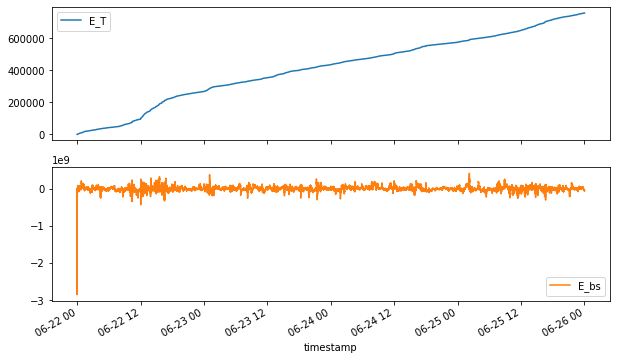

In [18]:
doller_ib[['E_T','E_bs']].plot(subplots=True, figsize=(10,6));

In [19]:
# 区間によるドルバー期待値を超えたかをチェックする関数
def test_t_abs(absTheta,t,E_bs):
    """
    Bool function to test inequality
    *row is assumed to come from df.itertuples()
    -absTheta: float(), row.absTheta
    -t: pd.Timestamp()
    -E_bs: float(), row.E_bs
    """
    #print(absTheta)
    #print(t*E_bs)
    return (absTheta >= t*E_bs)

# 区間によるドルバー期待値を超えた場合に、区間を取得する関数
def agg_imbalance_bars(df):
    """
    Implements the accumulation logic
    """
    start = df.index[0]  
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta
        rowIdx = row.Index
        E_bs = row.E_bs
        
        t = df.loc[start:rowIdx].shape[0]
        if t<1: t=1 # if t lt 1 set equal to 1
        if test_t_abs(t_abs,t,E_bs):
            bars.append((start,rowIdx,t))
            start = rowIdx
    return bars

In [20]:
bars = agg_imbalance_bars(doller_ib)
test_imb_bars = (pd.DataFrame(bars,columns=['start','stop','Ts'])
                 .drop_duplicates())

test_imb_bars.tail()

,start,stop,Ts
758589,2021-06-25 23:59:55.554345,2021-06-25 23:59:55.554345,2
758590,2021-06-25 23:59:55.554345,2021-06-25 23:59:55.966135,3
758591,2021-06-25 23:59:55.966135,2021-06-25 23:59:59.894261,3
758592,2021-06-25 23:59:59.894261,2021-06-25 23:59:59.894261,2
758593,2021-06-25 23:59:59.894261,2021-06-25 23:59:59.995359,3


In [21]:
test_imb_bars.Ts.describe().round()

count    492137.0
mean          4.0
std           5.0
min           1.0
25%           2.0
50%           3.0
75%           4.0
max         552.0
Name: Ts, dtype: float64

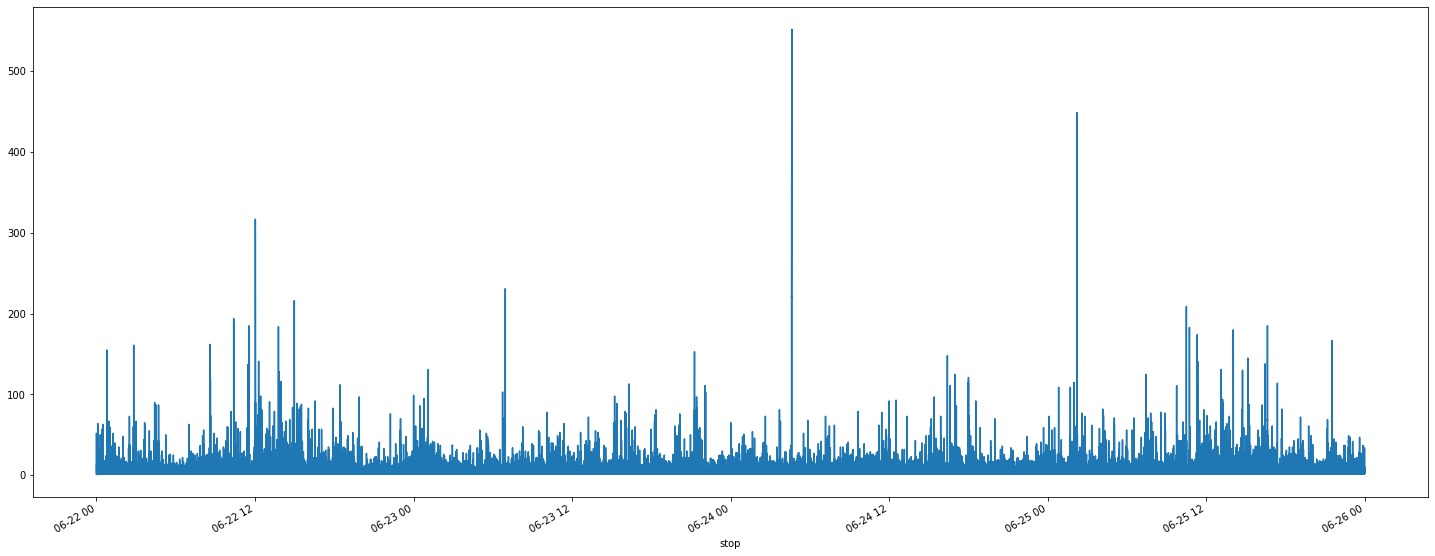

In [22]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [79]:
#dvImbBars = df.price.loc[test_imb_bars.stop].drop_duplicates()

#imb_bar = test_imb_bars.stop
xdata3 = data[data['timestamp'] > dt.datetime(2021,6,25,23)]
imb_bar = test_imb_bars[test_imb_bars['stop'] > dt.datetime(2021,6,25,23)]
print(imb_bar)

bar_price = []
bar_timestamp = []
for row in imb_bar.stop:
  price_val = xdata3.loc[xdata3['timestamp'] == row]
  #print(price_val.price.drop_duplicates)
  bar_price.append(price_val.price.iloc[-1])
  bar_timestamp.append(row)
# データフレームに変換

price_df = pd.DataFrame(list(zip(bar_timestamp,bar_price)), columns = ['timestamp','price'])
print(len(bar_price))
print(type(bar_price))
price_df.tail()

                            start                       stop  Ts
752191 2021-06-25 22:59:58.299252 2021-06-25 23:00:01.772832   2
752192 2021-06-25 23:00:01.772832 2021-06-25 23:00:01.959304   2
752193 2021-06-25 23:00:01.959304 2021-06-25 23:00:02.931356   2
752194 2021-06-25 23:00:02.931356 2021-06-25 23:00:03.679982   3
752195 2021-06-25 23:00:03.679982 2021-06-25 23:00:03.679982   2
...                           ...                        ...  ..
758589 2021-06-25 23:59:55.554345 2021-06-25 23:59:55.554345   2
758590 2021-06-25 23:59:55.554345 2021-06-25 23:59:55.966135   3
758591 2021-06-25 23:59:55.966135 2021-06-25 23:59:59.894261   3
758592 2021-06-25 23:59:59.894261 2021-06-25 23:59:59.894261   2
758593 2021-06-25 23:59:59.894261 2021-06-25 23:59:59.995359   3

[4371 rows x 3 columns]
4371
<class 'list'>


,timestamp,price
4366,2021-06-25 23:59:55.554345,31568.0
4367,2021-06-25 23:59:55.966135,31562.5
4368,2021-06-25 23:59:59.894261,31562.5
4369,2021-06-25 23:59:59.894261,31562.5
4370,2021-06-25 23:59:59.995359,31562.5


(6403, 11)
(4371, 2)


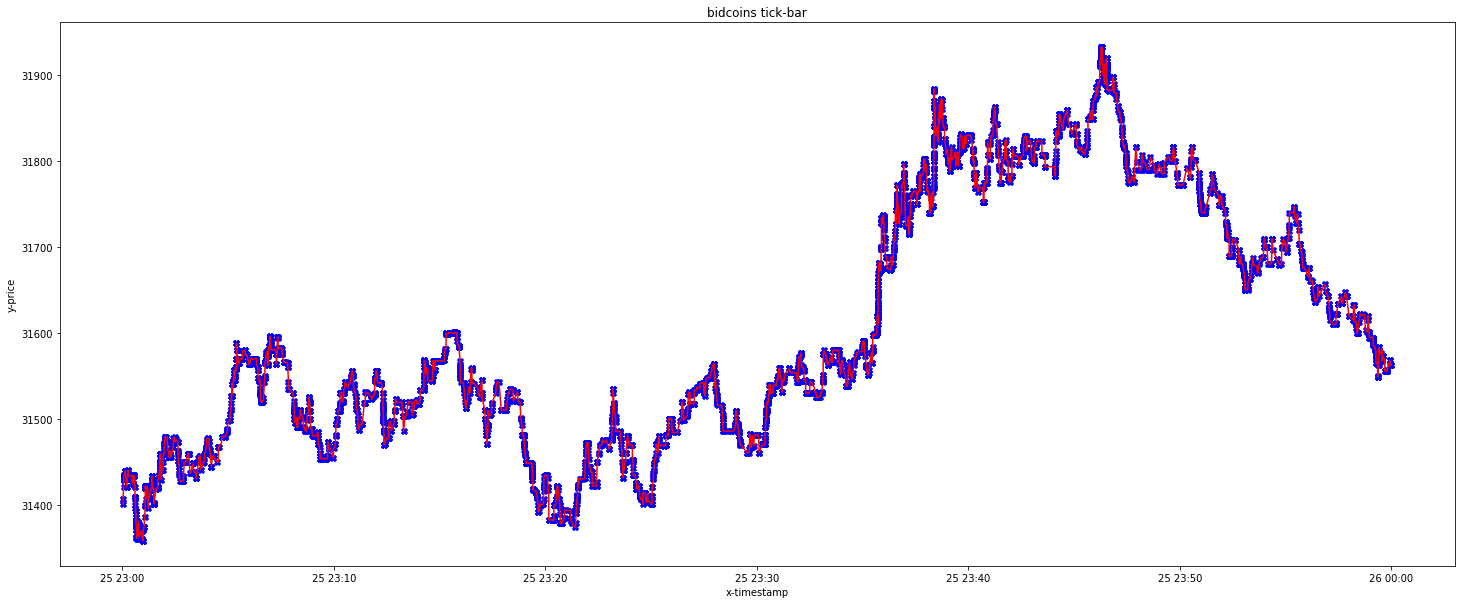

In [81]:
x1=xdata3['timestamp']
y1=xdata3['price']
print(xdata3.shape)

x2=price_df['timestamp']
y2=price_df['price']
print(price_df.shape)

# グラフの描画
plt.rcParams["figure.figsize"] = (25, 13)

plt.plot(x1, y1, color = "red")
plt.scatter(x2, y2, marker='X', color = "blue")

plt.title("bidcoins tick-bar")
plt.xlabel('x-timestamp')
plt.ylabel('y-price')

plt.show()

## 別のサンプル

https://quant.stackexchange.com/questions/44476/tick-imbalance-bars-advances-in-financial-machine-learning

https://towardsdatascience.com/information-driven-bars-for-finance-c2b1992da04d

In [ ]:
import numpy as np

# Generate tick imbalanced bars id of every tick by computing: get_bars_ids(get_b(ticks))
class Tick_Imbalance():
  def __init__(self, alpha_T, alpha_imbalance, expected_imbalance, expected_ticks):
    self.T = 0
    self.bar_id = 0
    self.imbalance = 0
    self.expected_tick_imbalance = expected_imbalance * expected_ticks

    self.alpha_ticks = alpha_T
    self.alpha_imbalance = alpha_imbalance
    self.EWMA_ticks = expected_ticks
    self.EWMA_imbalance = expected_imbalance


  def __get_EWMA(self, alpha, rt, EWMA_0):
    return alpha * rt + (1 - alpha) * EWMA_0

  def __get_b(self, price_change):
    if price_change == 0: return self.last_b
    self.last_b = abs(price_change)/price_change

    return self.last_b

  def get_b(self, price_ticks: np.ndarray) -> np.ndarray:
    price_change = (price_ticks[1:] - np.roll(price_ticks, 1)[1:]) / np.roll(price_ticks, 1)[1:]
    b = [self.__get_b(x) for x in price_change]

    return np.asarray(b)

  def get_bar_ids(self, b: np.ndarray) -> np.ndarray:
    bars_ids = []    
    for _imbalance in b:
      self.T += 1
      self.imbalance += _imbalance

      self.EWMA_imbalance = self.__get_EWMA(self.alpha_imbalance, _imbalance, self.EWMA_imbalance)

      bars_ids.append(self.bar_id)

      if abs(self.imbalance) >= self.expected_tick_imbalance:
        self.EWMA_ticks = self.__get_EWMA(self.alpha_ticks, self.T, self.EWMA_ticks)
        
        self.expected_tick_imbalance = self.EWMA_ticks * abs(self.EWMA_imbalance)

        self.T = 0
        self.imbalance = 0
        self.bar_id += 1
  
    return np.asarray(bars_ids)
  

In [ ]:
tick_inbalance = Tick_Imbalance( 0.5, 100, 100, 200)
df_tick_inbalane_bar = tick_inbalance.get_bar_ids(tick_inbalance.get_b(data['price']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


    :parameter: tick_imbalances: list of tick signs - either a +1 or a -1
    :parameter: in_T: initialization value for the expected number of ticks
    :parameter: in_b: initialization value for the expected imbalance
    :parameter: alpha: alpha to update the EWMA(T) 0.5